In [6]:
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
import matplotlib.pyplot as plt
import numpy as np

In [7]:
movie = cm.load('../data/Sue_2x_3000_40_-46.tif')

In [8]:
movie.play(plot_text=True, fr=0.5) 

In [9]:
MotionCorrect?

Init signature:
MotionCorrect(
    fname,
    min_mov=None,
    dview=None,
    max_shifts=(6, 6),
    niter_rig=1,
    splits_rig=14,
    num_splits_to_process_rig=None,
    strides=(96, 96),
    overlaps=(32, 32),
    splits_els=14,
    num_splits_to_process_els=None,
    upsample_factor_grid=4,
    max_deviation_rigid=3,
    shifts_opencv=True,
    nonneg_movie=True,
    gSig_filt=None,
    use_cuda=False,
    border_nan=True,
    pw_rigid=False,
    num_frames_split=80,
    var_name_hdf5='mov',
    is3D=False,
    indices=(slice(None, None, None), slice(None, None, None)),
)
Docstring:      class implementing motion correction operations
Init docstring:
 Constructor class for motion correction operations

 Args:
    fname: str
        path to file to motion correct

    min_mov: int16 or float32
        estimated minimum value of the movie to produce an output that is positive

    dview: ipyparallel view object list
        to perform parallel computing, if NOne will operate in si

In [10]:
mc = MotionCorrect(
    movie,
    pw_rigid=True,
    strides=(48, 48),
    overlaps=(24, 24),
    max_shifts=(6,6),
    max_deviation_rigid=3,
    )
mot_corr = mc.motion_correct(save_movie=True)
movie_corr = cm.load(mc.mmap_file)

100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


In [11]:
movie_corr.play()

Source extraction

In [12]:
cnmf.CNMF?

Init signature:
cnmf.CNMF(
    n_processes,
    k=5,
    gSig=[4, 4],
    gSiz=None,
    merge_thresh=0.8,
    p=2,
    dview=None,
    Ain=None,
    Cin=None,
    b_in=None,
    f_in=None,
    do_merge=True,
    ssub=2,
    tsub=2,
    p_ssub=1,
    p_tsub=1,
    method_init='greedy_roi',
    alpha_snmf=0.5,
    rf=None,
    stride=None,
    memory_fact=1,
    gnb=1,
    nb_patch=1,
    only_init_patch=False,
    method_deconvolution='oasis',
    n_pixels_per_process=4000,
    block_size_temp=5000,
    num_blocks_per_run_temp=20,
    block_size_spat=5000,
    num_blocks_per_run_spat=20,
    check_nan=True,
    skip_refinement=False,
    normalize_init=True,
    options_local_NMF=None,
    minibatch_shape=100,
    minibatch_suff_stat=3,
    update_num_comps=True,
    rval_thr=0.9,
    thresh_fitness_delta=-20,
    thresh_fitness_raw=None,
    thresh_overlap=0.5,
    max_comp_update_shape=inf,
    num_times_comp_updated=inf,
    batch_update_suff_stat=False,
    s_min=None,
    remove_v

In [24]:
border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0 # trim border against NaNs
mem_map_file = cm.save_memmap(mc.mmap_file, order='C', border_to_0=border_to_0)


In [25]:
Yr, dims, num_frames = cm.load_memmap(mem_map_file)
images = np.reshape(Yr.T, [num_frames] + list(dims), order='F') #reshape frames in standard 3d format (T x X x Y)

In [28]:
cnmf_model = cnmf.CNMF(n_processes=1)
cnmf_fit = cnmf_model.fit(images)

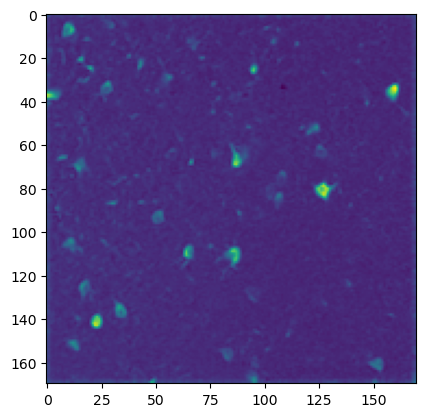

In [29]:
correlation_image = cm.local_correlations(movie_corr, swap_dim=False)
plt.imshow(correlation_image)


In [34]:
cnmf_fit.estimates.plot_contours_nb(img=correlation_image, cmap='gray')